In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import precision_score, recall_score
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import make_scorer
from keras import backend as K
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer

In [2]:
import pandas as pd

ctu13_attack = pd.read_csv('data/CTU13_Attack_Traffic.csv')
ctu13_normal = pd.read_csv('data/CTU13_Normal_Traffic.csv')

In [3]:
combined_dataset = pd.concat([ctu13_normal, ctu13_attack], ignore_index=True)

In [4]:
combined_dataset = combined_dataset.sample(frac=1).reset_index(drop=True)

In [5]:
combined_dataset.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
combined_dataset.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Act Data Pkts,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6149589,5,5,599,152,517,0,119.8,223.09796,152,...,3,107258.0,0.0,107258,107258,6041971.0,0.0,6041971,6041971,0
1,114239,1,1,0,0,0,0,0.0,0.00000,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0
2,22586,0,2,0,114,0,0,0.0,0.00000,71,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0
3,53339,0,2,0,255,0,0,0.0,0.00000,226,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0
4,47374,0,2,0,229,0,0,0.0,0.00000,184,...,0,0.0,0.0,0,0,0.0,0.0,0,0,0


In [7]:
total_rows = combined_dataset.shape[0]
print(total_rows)

92212


In [8]:
print(ctu13_normal.shape)
print(ctu13_attack.shape)

(53314, 59)
(38898, 59)


In [9]:
combined_df=pd.DataFrame(combined_dataset)

interval columns not set, guessing: ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'ACK Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']


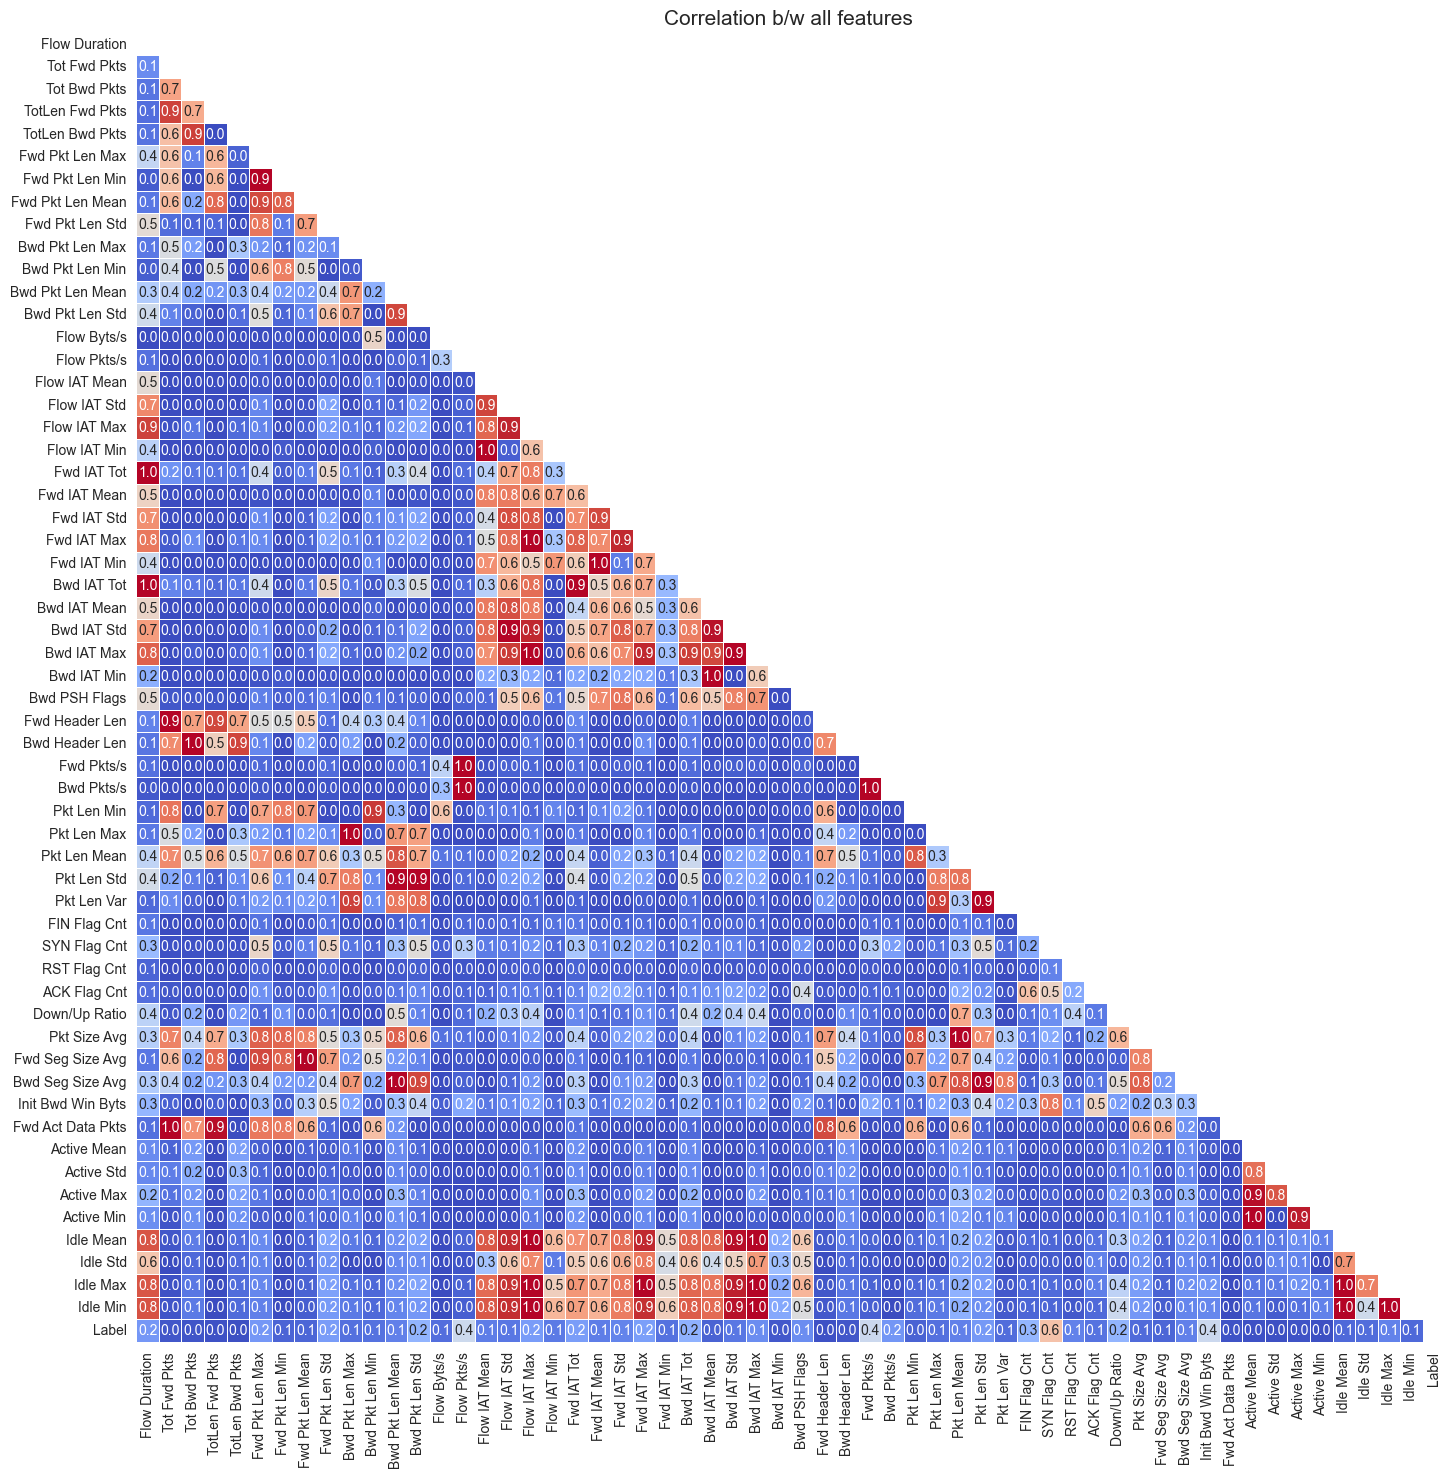

In [10]:
import phik
import seaborn as sns
import matplotlib.pyplot as plt

Phi_corr = combined_df.phik_matrix()

mask = np.zeros_like(Phi_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  fig, ax = plt.subplots(figsize=(20,17))         # Sample figsize in inches
  plot = sns.heatmap(Phi_corr, mask=mask, annot=True, fmt='.1f',linewidths=.5, ax=ax,cmap='coolwarm',robust=True, square=True,cbar=False) #annot=True writes data in rect boxes
  plt.title('Correlation b/w all features ',size = 15)
  plt.show()

From the above correlation matrix it is clear that most of the numerical features are having less or no correlation with Rating variable. 
Most of the numerical features within columns are highly correlated with each other. It means a small change in one feature impacts changes in another feature.

In [11]:
print('\033[1m' + "Below are the top 10 correlated features to 'Rating' variable" + '\033[0m')
print(Phi_corr['Label'].sort_values(ascending=False)[0:10])

Below are the top 10 correlated features to 'Rating' variable
Label                1.000000
SYN Flag Cnt         0.586909
Flow Pkts/s          0.407066
Fwd Pkts/s           0.406356
Init Bwd Win Byts    0.404661
FIN Flag Cnt         0.252643
Bwd Pkt Len Std      0.245928
Down/Up Ratio        0.245826
Bwd IAT Tot          0.238764
Fwd IAT Max          0.186137
Name: Label, dtype: float64


In [12]:
X, y = combined_df.drop('Label', axis=1), combined_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
corr = combined_df.corr()

Dropping Columns with Zero Correlation

In [13]:
import numpy as np

# Assuming 'corr' is your correlation matrix
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # numerical features that are highly correlated with each other
corr_col = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

Phi_corrFea = (Phi_corr['Label'].sort_values(ascending=False) == 0)  # Features that have zero or no correlation with target variable
no_cor = [col for col in X_train.columns if Phi_corrFea[col]]

drop_num = [col for col in corr_col if col not in no_cor]  # Dropping Features that are having zero correlation with the target variable but are highly correlated with other variables
 #Dropping Features that are having zero correlation with the target variable but are highly correlated with other variables  
drop_num

['TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Max',
 'Bwd IAT Tot',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd Act Data Pkts',
 'Active Max',
 'Active Min',
 'Idle Mean',
 'Idle Max',
 'Idle Min']

In [14]:
scoring = {'precision': make_scorer(precision_score, average='binary'),
           'recall': make_scorer(recall_score, average='binary')}

In [15]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

svm_param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

gbm_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2]
}

xgb_param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}


In [16]:
def custom_scorer(y_true, y_pred):
    return recall_score(y_true, np.round(y_pred), average='binary')

In [17]:
# Create pipelines for SVM and LSTM models with standard scaling
svm_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [18]:
svm_param_grid = {'svc__C': [0.1, 1, 10, 100],
                  'svc__gamma': [1, 0.1, 0.01, 0.001],
                  'svc__kernel': ['rbf']}


# Define classifiers and parameter grids
classifiers = [
    ('Random Forest', RandomForestClassifier(), rf_param_grid),
    ('SVM', svm_pipe, svm_param_grid),
    ('Gradient Boosting', GradientBoostingClassifier(), gbm_param_grid),
    ('XGBoost', xgb.XGBClassifier(), xgb_param_grid),
]

In [19]:
results = {}
for name, clf, param_grid in classifiers:
    print("Training", name)
    
    # Perform grid search
    clf_gs = GridSearchCV(clf, param_grid, scoring=scoring, refit='precision', cv=5, verbose=1)
    clf_gs.fit(X_train, y_train)
    
    # Best parameters and results
    print("Best parameters found:", clf_gs.best_params_)
    print("Best precision:", clf_gs.best_score_)
    print("Best recall:", clf_gs.cv_results_['mean_test_recall'][clf_gs.best_index_])
    
    # Store results
    results[name] = {
        'precision': clf_gs.best_score_,
        'recall': clf_gs.cv_results_['mean_test_recall'][clf_gs.best_index_],
        'best_params': clf_gs.best_params_
    }
    
    # Predict on test set
    y_pred = clf_gs.predict(X_test)
    print(classification_report(y_test, y_pred))

Training Random Forest
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'max_depth': 20, 'n_estimators': 200}
Best precision: 0.9972421437267321
Best recall: 0.996826614842122
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10742
           1       0.99      1.00      1.00      7701

    accuracy                           1.00     18443
   macro avg       1.00      1.00      1.00     18443
weighted avg       1.00      1.00      1.00     18443

Training SVM
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'svc__C': 100, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
Best precision: 0.9962293127858706
Best recall: 0.9568548183264083
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     10742
           1       0.99      0.96      0.98      7701

    accuracy                           0.98     18443
   macro avg       0.98  

In [20]:
# Comparison of precision and recall
print("\nComparison of Precision and Recall:")
print("{:<20} {:<10} {:<10}".format('Model', 'Precision', 'Recall'))
for name, metrics in results.items():
    print("{:<20} {:<10.4f} {:<10.4f}".format(name, metrics['precision'], metrics['recall']))


Comparison of Precision and Recall:
Model                Precision  Recall    
Random Forest        0.9972     0.9968    
SVM                  0.9962     0.9569    
Gradient Boosting    0.9971     0.9956    
XGBoost              0.9979     0.9970    


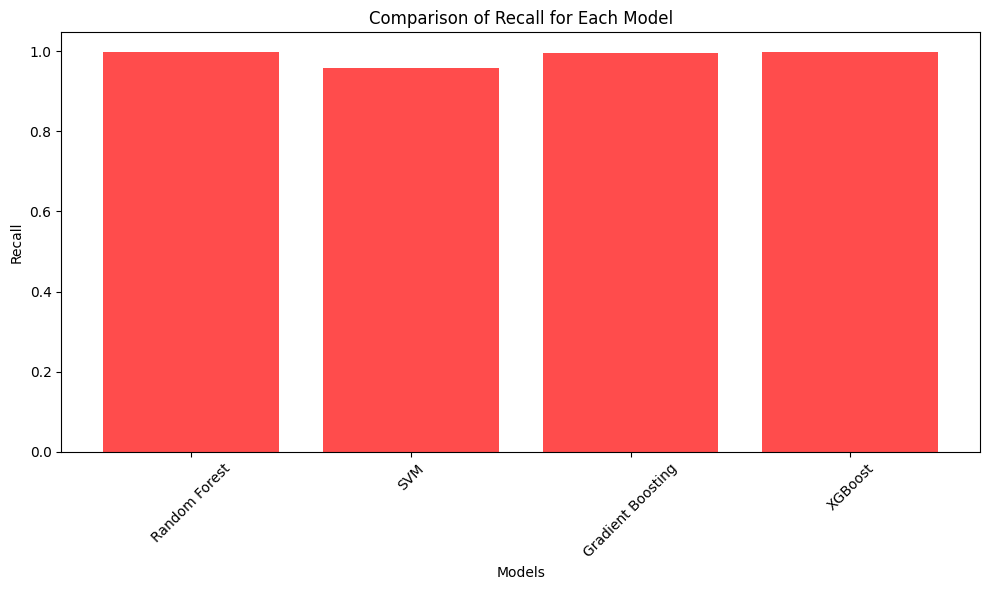

In [21]:
import matplotlib.pyplot as plt

# Extract recall values for plotting
model_names = list(results.keys())
recalls = [metrics['recall'] for metrics in results.values()]

# Plotting Recall
plt.figure(figsize=(10, 6))
plt.bar(model_names, recalls, color='r', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Comparison of Recall for Each Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



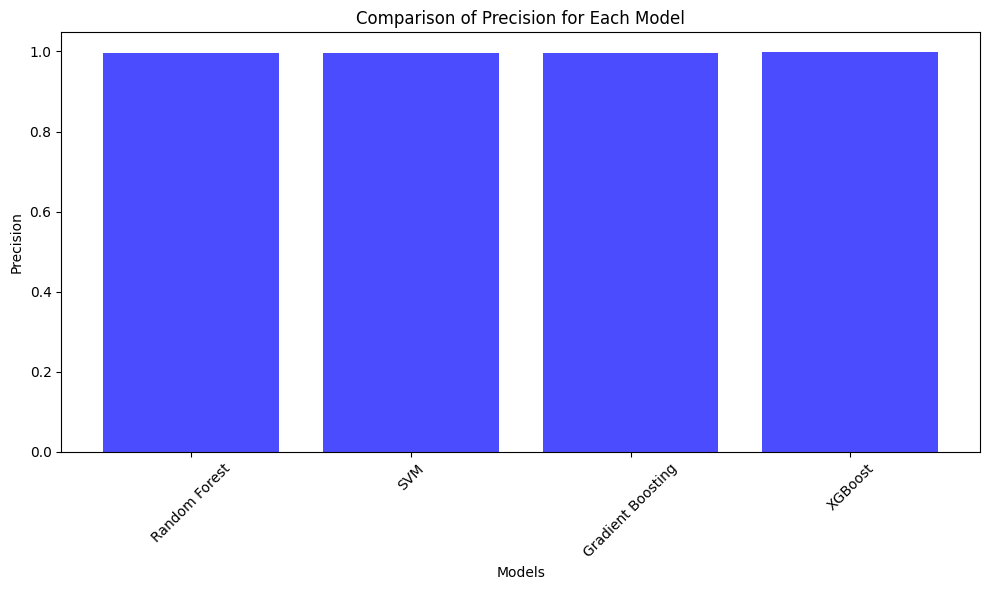

In [22]:
# Extract precision values for plotting
precisions = [metrics['precision'] for metrics in results.values()]

# Plotting Precision
plt.figure(figsize=(10, 6))
plt.bar(model_names, precisions, color='b', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Comparison of Precision for Each Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


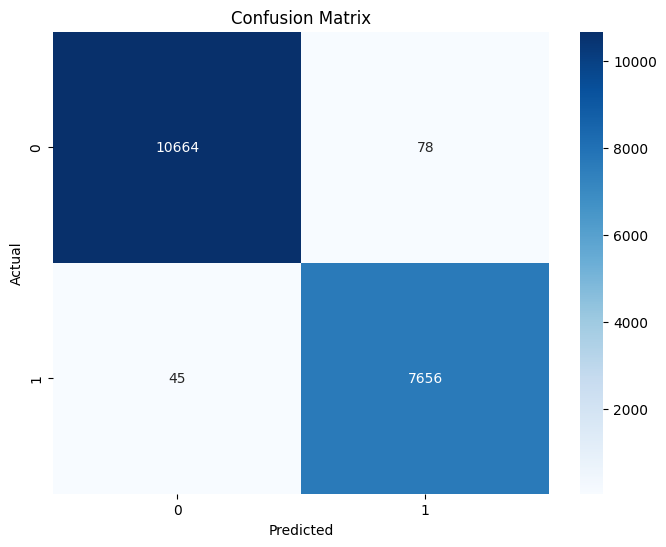

In [23]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': 3,  # Number of classes
    'max_depth': 3,  # Maximum tree depth
    'learning_rate': 0.1,  # Learning rate
    'n_estimators': 100  # Number of trees
}

best_model = xgb.XGBClassifier(**params)
best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
import joblib

# Save the trained model to a file
joblib.dump(best_model, 'Cyber_security_gbm.pkl')

['Cyber_security_gbm.pkl']

In [25]:
y_pred_probs = best_model.predict_proba(X_test)[:,1]

In [26]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import joblib
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import SelectionSlider, interact
from functools import cache
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs,pos_label=1)
# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_probs)

interactive(children=(SelectionSlider(continuous_update=False, description='Thresh', index=437, options=(inf, …

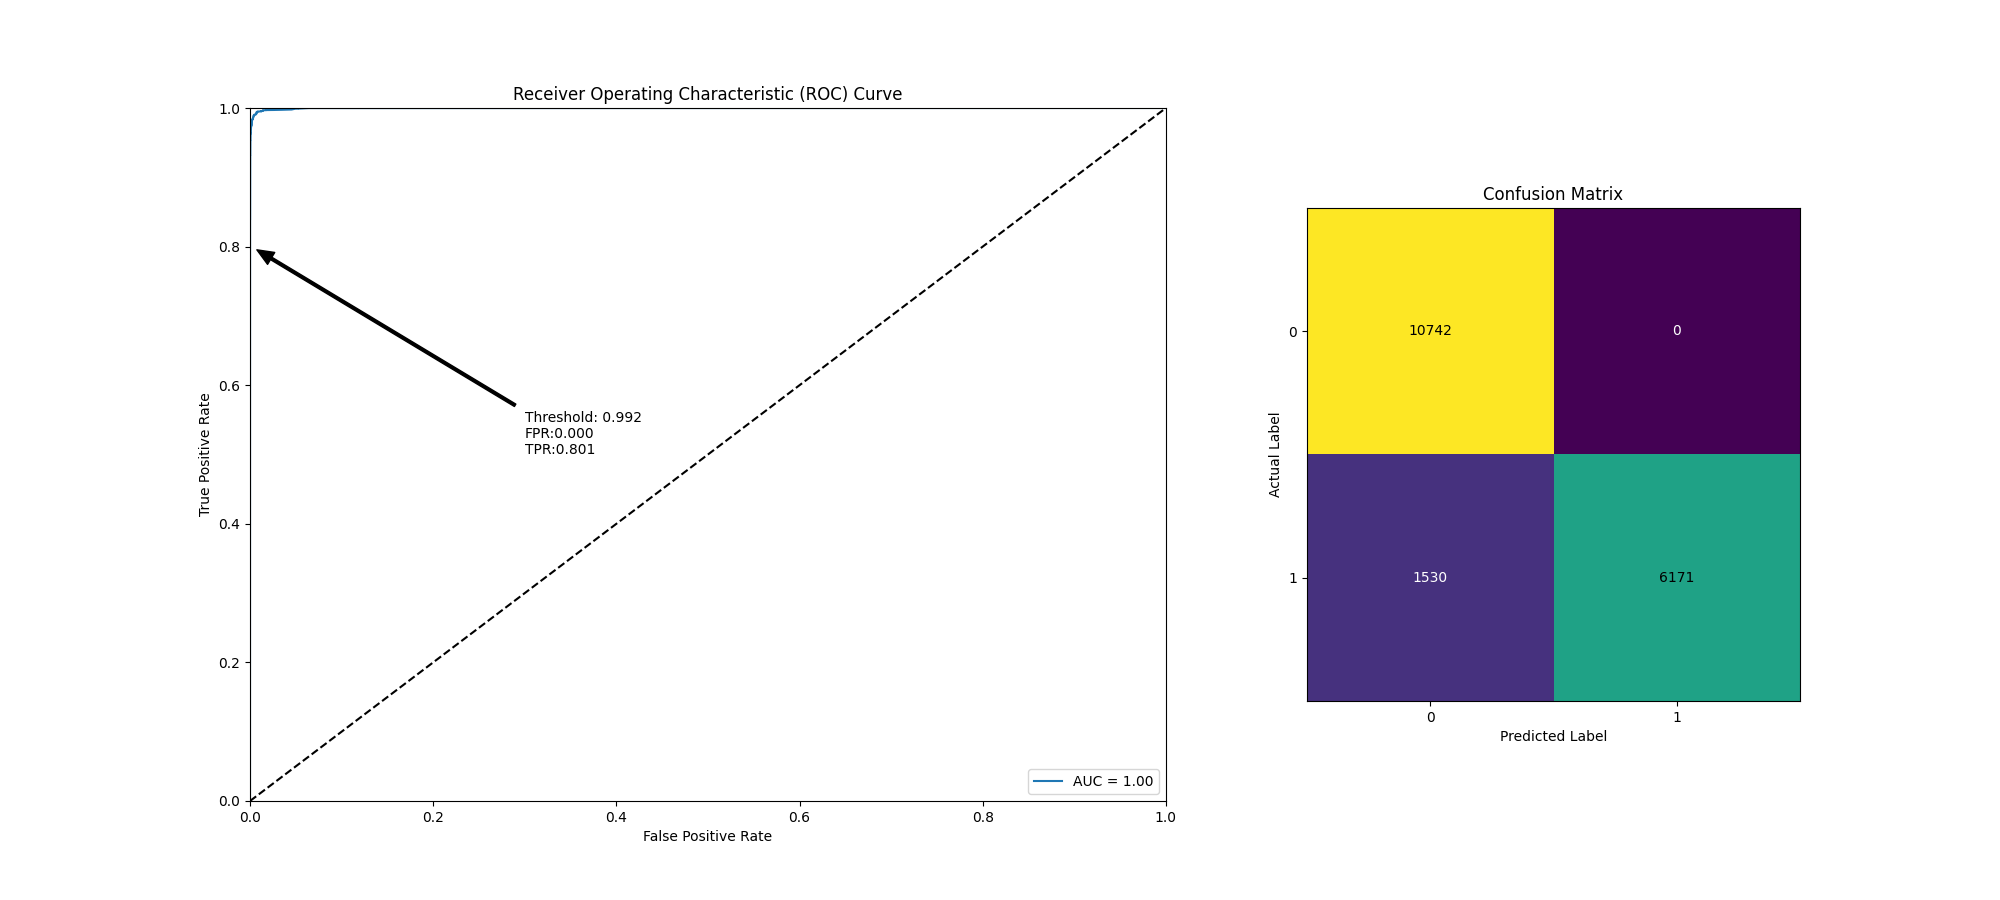

In [27]:
%matplotlib widget
n_thresh = len(thresholds)
n_thresh_str = len(str(n_thresh))
idx = 0

fig, ax = plt.subplots(figsize=(20, 9),ncols=2, gridspec_kw={"width_ratios":[0.65,0.35]})
ax[0].plot(fpr, tpr, label=f'AUC = {auc:.2f}')
ax[0].plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference (random classifier)
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc="lower right")

# Everything below needs to be updated when slider moves.
ann = ax[0].annotate(xy=(fpr[idx], tpr[idx]), text=f"Threshold: {thresholds[idx]:0.3f}\nFPR:{fpr[idx]:0.3f}\nTPR:{tpr[idx]:0.3f}", xytext=(0.3,0.5), textcoords=ax[0].transAxes, arrowprops={"color":"black","shrink":0.025, "width":2.0, "headwidth": 10.0});
y_preds_thresh = (y_pred_probs >=  thresholds[idx]).astype(int)
cm = confusion_matrix(y_test, y_preds_thresh)

text_labels = {}
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_labels[(i,j)] = ax[1].text(j,i,s=cm[i,j],ha="center",va="center",color="black" if cm[i,j] > np.mean(cm) else "white")
cm_img = ax[1].imshow(cm)
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted Label")
ax[1].set_xticks([0,1])
ax[1].set_ylabel("Actual Label")
ax[1].set_yticks([0,1])

slider = SelectionSlider(
    options=thresholds,
    value=thresholds[np.argwhere(fpr == 0).squeeze(axis=1)[-1]],
    description='Thresh',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
@cache
@interact(thresh=slider)
def update_plot(thresh):
    global idx
    idx = np.argwhere(thresh == thresholds).squeeze()
    # Update the arrow
    ann.xy = (fpr[idx],tpr[idx])
    ann.set_text(f"Threshold: {thresholds[idx]:0.3f}\nFPR:{fpr[idx]:0.3f}\nTPR:{tpr[idx]:0.3f}")
    # Update thresholded predictions
    y_preds_thresh = (y_pred_probs >= thresholds[idx]).astype(int)
    # Make new confusion matrix
    cm = confusion_matrix(y_test, y_preds_thresh)
    # Update confusion matrix image.
    cm_img.set_data(cm)
    # Update confusion matrix labels
    for (t_i, t_j), text in text_labels.items():
        text.set_text(cm[t_i,t_j])
        text.set_color("black" if cm[t_i,t_j] > np.mean(cm) else "white")

In [28]:
# Define the desired threshold
thresh = 0.991943

# Apply the threshold to predicted probabilities
y_preds_thresh = (y_pred_probs >= thresh).astype(int)

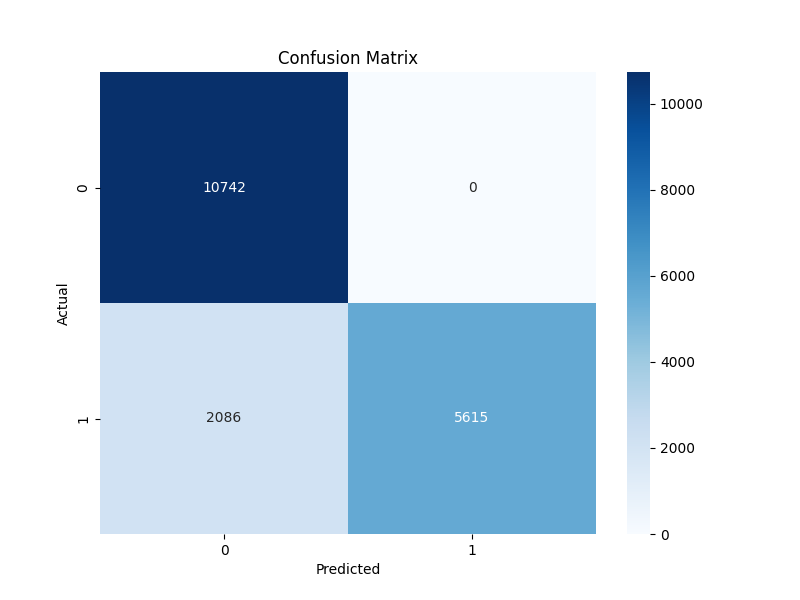

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_preds_thresh)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()